# **Geospatial Regular grid model with MODFLOW6**

In [55]:
%matplotlib widget
from timeit import default_timer as timer # to measure exec time
import matplotlib.pyplot as plt
import os, glob, warnings
import numpy as np
import geopandas as gpd
import flopy as fp
import shapefile as shf

import folium as flm
import shapely
from shapely.geometry import Polygon, LineString, Point
from flopy.utils.gridgen import Gridgen
from flopy.mf6.utils.reference import SpatialReference
#import pyvista as pv

from definitions import ROOT_DIR, FLOPY_EXEC
from utils.flopy_utils import model_map, cells_coordinates 
from utils.io import geodf_map, dataframe_viewer, dict_viewer

#### Set flopy executables directories

In [2]:
work_dir = %pwd
model_name = "geosp_3dintersect"
model_files = f"{model_name}_files"
grdg_dir = model_files+'/gridgen'
shp_dir = f'{work_dir}/{model_files}/shp' # saving generated files (shp, raster, vtk, ...)

In [4]:
os.system(f'rm -fr {model_files}')
my_path = [model_files, grdg_dir, shp_dir]
for x in my_path: 
    if not os.path.exists(x): 
        os.mkdir(x)

# 1. Reading of shapefiles/geopackages

In [4]:
gpkg_dir = f'{ROOT_DIR}/qgis/Geopackages'
gpkg_files = glob.glob(f'{gpkg_dir}/*.gpkg', recursive=True)
gpkg_names = [txt.replace(f'{gpkg_dir}/', '').replace('.gpkg', '') for txt in gpkg_files]
assert gpkg_files # check if files list is not empty
print(gpkg_names)

['Galeries', 'Parties_exploitees', 'Shaft']


In [5]:
gdfs = [gpd.read_file(shp) for shp in gpkg_files[:3]]
gpkg_names = gpkg_names[:3]
geom_type = [list(set(gdf.geometry.geom_type))[0] for gdf in gdfs]

gpkg_dict = {'data':gdfs, 'name':gpkg_names, 'geom_type':geom_type}

In [6]:
for n, x in enumerate(gpkg_dict['data']): 
    for c in x.columns: # erase ' ' at the end of columns names
        x.rename(columns={f'{c}':c.rstrip(' ')}, inplace=True)
        
    print(n, x.columns)

0 Index(['Type', 'Profondeur', 'geometry'], dtype='object')
1 Index(['Année', 'Couche', 'geometry'], dtype='object')
2 Index(['Nom', 'Début ou fin', 'geometry'], dtype='object')


In [7]:
for n in range(3):
    print(gpkg_dict['name'][n])
    dataframe_viewer(gpkg_dict['data'][n])#.sort_values('Type'))

Galeries
Rows : 761, columns : 3


/home/yanathan/.local/share/virtualenvs/Geotherma-DQtWNVFx/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=10, description='rows', max=761, min=10, readout=False), IntSlider(value…

Parties_exploitees
Rows : 850, columns : 3


interactive(children=(IntSlider(value=10, description='rows', max=850, min=10, readout=False), IntSlider(value…

Shaft
Rows : 34, columns : 3


interactive(children=(IntSlider(value=10, description='rows', max=34, min=10, readout=False), IntSlider(value=…

In [8]:
n=0
col = 'Type'
to_find = ['^[b|B]ouv', '[l|L]ien.?$', 'Lien bou', '[v|V]oi.?',]
repl_with = ['Bouveau', 'Lien', 'Lien bouveaux', 'Voie']

for i, x in enumerate(to_find):
    new_val = ''
    qry = gpkg_dict['data'][n].query(f'{col}.str.contains("{x}")')[col]
    if len(set(qry))>1:
        if repl_with is None: 
            print('\nmany values', set(qry))
            new_val = input('uniform with (Enter if no change):')
        else:
            new_val = repl_with[i]
            print(f'\nmany values {set(qry)} have been replaced by : \'{new_val}\'')
        if len(new_val)>0:
            gpkg_dict['data'][n].loc[qry.index, col] = new_val.capitalize()
print('\n--> Results :', set(gpkg_dict['data'][n][col]))


many values {'Bouvea', 'Bouveau', 'Bouveau '} have been replaced by : 'Bouveau'

many values {'lien ', 'Lien'} have been replaced by : 'Lien'

many values {'Lien bouveau ', 'Lien bouveaux'} have been replaced by : 'Lien bouveaux'

many values {'Voie ', 'Voie'} have been replaced by : 'Voie'

--> Results : {'Lieb', 'Burquin', 'Bouveau', 'Lien Veines', 'Recoutelage', 'Voie', 'Lien bouveaux', 'Lien'}


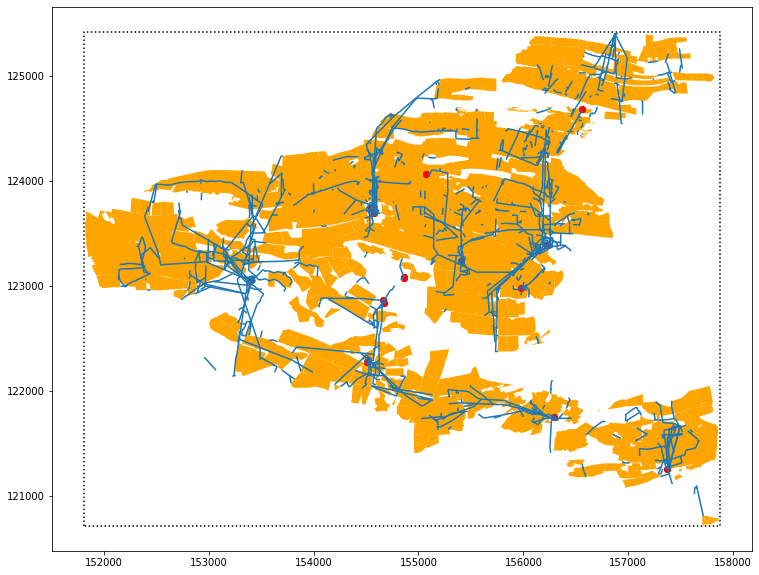

((6066.437133657775, 4711.588183117841),
 [(151809.84956436296, 157876.28669802073),
  (120712.49326382068, 125424.08144693852)])

In [9]:
area_bbox, area_lw = geodf_map(gpkg_dict['data'], plot=True, _return=True, expand=(10, 10), 
                               colors=[None, 'orange', 'red'], figsize=(20,10))
area_lw, area_bbox

* Saving geopackage to shapefile

#### Retrieve each feature ('line', 'point', 'polygon') min/max coordinates

In [10]:
min_max_dict = {} # coordinates min/max per file
ftr_z = {} # keep all rounded Z per file
for n in range(len(gpkg_dict['data'])):
    data = gpkg_dict['data'][n]
    points = []
    for i in data.index:
        ftr = data.geometry[i] # linestring
        cd_txt = ftr.wkt[ftr.wkt.find('('):].strip('()') # coords extraction as string
        for cd in cd_txt.split(', '):
            p = cd.split(' ')
            points.append([float(i) for i in p])

    xmin = np.nanmin([p[0] for p in points])
    ymin = np.nanmin([p[1] for p in points])
    zmin = np.nanmin([p[2] for p in points]) # Z can be negative !!

    xmax = np.nanmax([p[0] for p in points])
    ymax = np.nanmax([p[1] for p in points])
    zmax = np.nanmax([p[2] for p in points])
    
    z = list(set([round(p[2]) for p in points]))
    
    ftr_z.update({gpkg_dict['name'][n]: z})
    min_max_dict.update({gpkg_dict['name'][n]: [(xmin, ymin, min(zmin, zmax)), (xmax, ymax, max(zmin, zmax))]})

In [11]:
dict_viewer(min_max_dict)

Galeries,"[(152137.62264056425, 120804.60895671032, -1070.5), (157716.27208650328, 125414.08144693852, 121.0)]"
Parties_exploitees,"[(151819.84956436296, 120722.49326382068, -1078.3), (157866.28669802073, 125401.77885709287, 144.0)]"
Shaft,"[(153391.94, 121261.4879999999, -1063.4), (157366.95900000018, 124685.816, 155.39)]"


(array([175., 224., 143., 115.,  74.]),
 array([-1070. ,  -831.8,  -593.6,  -355.4,  -117.2,   121. ]),
 <BarContainer object of 5 artists>)

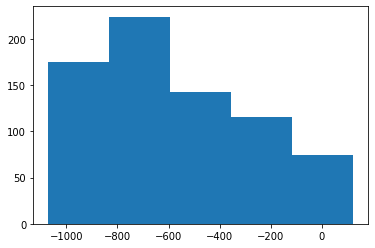

In [12]:
# numerical approach for vertical discretization (not based on geology !)
# Model will contain 5 layers of 247m thick
plt.hist([x for x in ftr_z.values()][0], bins=5) # histogram of Z

# 2. Model building and simulation

## Create MODFLOW6 components for a simulation

#### Create a simulation object (SIM)

In [13]:
sim = fp.mf6.MFSimulation(sim_name=model_name, exe_name=f"{FLOPY_EXEC}/mf6", version="mf6", sim_ws=model_files)

#### Create a temporal discretization object (TDIS)

In [14]:
#simulation of 366 days divided in 12 stress periods of 30 days, each stress period is divided in 3 time steps
#there is a steady state stress period at the beginning of the simulation

nper = 12 # nper = 1 --> if only steady-state simulation
perlen = np.ones(nper)
perlen[0] = 1
perlen[1:] = 30 * 86400 # time unit : second

#Definition of time steps
nstp = np.ones(nper) 
nstp[0] = 1 # first step is steady-state
nstp[1:] = 3

#Definition of stress period type: transient or steady state
periodType = np.zeros(nper, dtype=bool)
periodType[0] = True # steady-sate

#perdata = [(i,int(j),1) for i, j in zip(perlen, nstp)] # for transient
perdata = [(1., 1, 1.)] # for steady-state

In [15]:
tdis = fp.mf6.ModflowTdis(sim, pname="tdis", time_units="seconds", nper=1, perioddata=perdata)

#### Create an iterative model solution object (IMS)

In [16]:
ims = fp.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE", linear_acceleration="BICGSTAB")

#### Create a groundwater flow model object (GWF)

In [17]:
nam_file = f"{model_name}.nam"
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file=nam_file, save_flows=True, 
                           newtonoptions="NEWTON UNDER_RELAXATION",)

## Add internal packages to GWF (internal flow of the system)

#### discretization (DIS) Package

* Model's parameters

In [18]:
dict_viewer(min_max_dict)

Galeries,"[(152137.62264056425, 120804.60895671032, -1070.5), (157716.27208650328, 125414.08144693852, 121.0)]"
Parties_exploitees,"[(151819.84956436296, 120722.49326382068, -1078.3), (157866.28669802073, 125401.77885709287, 144.0)]"
Shaft,"[(153391.94, 121261.4879999999, -1063.4), (157366.95900000018, 124685.816, 155.39)]"


In [19]:
# aquifer geometry (grid) [units in meters]
cw = 50 # cell width
lth = 55 # constant layer thick
aq_th = 1235 # model global thickness
top = 156 # aquifer top
botm = np.arange((top-lth), -aq_th, -lth)   # bottom elevation for each cell/layer
Nlay = botm.shape[0] # number of layers 
delrow, delcol = np.round((np.array(area_lw)+cw)/cw) # column and row spacing (enlarge models sides with 50 m)
Nc, Nr = np.int_(np.round(np.array(area_lw)/[delrow, delcol])) # number of columns and rows (subdivisions)

In [20]:
dis = fp.mf6.ModflowGwfdis(gwf, nlay=Nlay, nrow=Nr, ncol=Nc, delr=delrow, delc=delcol, top=top, botm=botm, 
                           length_units='METERS')

In [21]:
gwf.modelgrid.set_coord_info(xoff=area_bbox[0][0], yoff=area_bbox[1][0], epsg=31370)

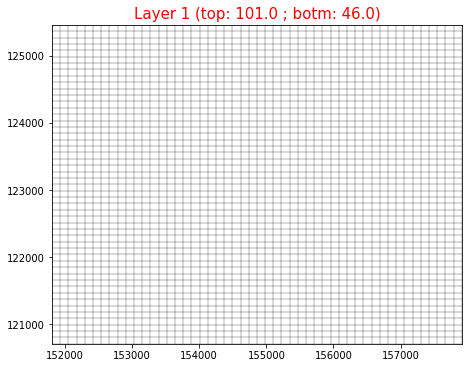

In [22]:
model_map(model=gwf, layer_line=1)

#### initial conditions (IC) Package

In [23]:
h0 = 1. # starting water head
start = h0 * np.ones((Nlay, Nr, Nc)) # creation of 3D vector filled with h1=100 to represent starting head

In [24]:
ic = fp.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

#### node property flow (NPF) Package

In [25]:
icelltype = np.zeros(Nlay)
k = np.ones(Nlay)*.0005 # horizontal hydraulic conductivity [m/s]
icelltype[0], k[0] = 1, .001
k33 = 2e-8 # vertical hydraumic conductivity

npf = fp.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k, k33=k33) # set cells properties
# icelltype = 1 --> cell is convertible ; 0 --> cell is confined

#### storage (STO) Package

## Retrieve all nodes coordinates like [node, (lrc), (xyz)]

## Intersect model with shapefiles

In [26]:
geodf_map(gpkg_dict['data'], inter_plot=True, colors=[None, 'orange', 'red'], layers_name=gpkg_names)

#### Gridgen object (manipulation of spatial data)

In [27]:
gdg = fp.utils.gridgen.Gridgen(gwf.dis, exe_name=f"{flopy_exec}/gridgen", model_ws=model_files, 
                               surface_interpolation='replicate')
gdg.build()

I got an issue with other geometry except for 'polygon'. To intersect with the correct layer, I loop on feature elements and find corresponding layer by element's Z

In [ ]:
pause

#### Grid intersection with features (Polygons, Lines, Points)

In [44]:
def gdf_feature_intersect(gridgen, data):
    """
        Intersect a feature ('point', 'line', 'polygon' and their relatives) with a model grid
        
        Parameters
        ------------
        gridgen : Gridgen object
        data : Geopandas.Dataframe object
    """
    lk = 0
    intv = np.unique(gridgen.modelgrid.top_botm)[::-1]
    isect_nodes = [] # intersected nodes number
    for idx in data.index:
        ftr = data.geometry[idx] # a feature ('point', 'line' or 'polygon')
        points = [i for i in ftr.exterior.coords]
        maxdepth = np.nanmin([p[2] for p in points]) # max depth reached by one of the feature elements
        
        # find layer based on max depth of the feature points
        for i in range(len(intv)-1):
            a, b = intv[i], intv[i+1] 
            if maxdepth >= min(a,b) and maxdepth < max(a,b):
                lk = i
                break
        print(ftr, maxdepth, lk)#, points)
        try:
            # Not really what i want. i must intersect the model with a geometry (plane, line, point)
            # the function intersect is effective when the geometry of the feature is horizontal (layer definition is obvious)
            isect_nodes += [x[0] for x in gridgen.intersect(features=[ftr], featuretype=ftr.type.lower(), layer=lk)]
        except Exception:
            print(f'intersection issue at data index {idx} | model layer {lk} | depth: {maxdepth}')
        break
    
    return isect_nodes

In [45]:
isect_nodes = gdf_feature_intersect(gdg, gpkg_dict['data'][1])
isect_nodes[:2]

POLYGON Z ((154613.67249129296 123991.1696439545 -663, 154628.1699573943 123988.16219088029 -663, 154655.54549178775 123983.84379672245 -664.3, 154674.36135204692 123980.83634364823 -664.8, 154692.17472794803 123977.59754802985 -665.2, 154723.71442813653 123972.23811242328 -666, 154758.1266315818 123965.79907827724 -667, 154772.82652240925 123963.18683538264 -668, 154791.95083939392 123959.78417212884 -669, 154811.57639855763 123956.19836269421 -671.1, 154816.51170616655 123955.31154960823 -671.3, 154826.86428501812 123798.69264720543 -700.8, 154813.2536320028 123798.84687556821 -703.2, 154800.76113461764 123798.84687556821 -705, 154776.47016747983 123799.1167752031 -710, 154761.35578792743 123798.38419047989 -711.7, 154725.34346521838 123799.54090320073 -718, 154716.41749872253 123800.69761592158 -719, 154697.23534610175 123800.69761592157 -720.2, 154672.09612296865 123799.29028211121 -720.3, 154637.89598352226 123799.09749665773 -720.4, 154626.63731303936 123801.29525082734 -720.6, 1

[38272, 38273]

/home/yanathan/.local/share/virtualenvs/Geotherma-DQtWNVFx/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/yanathan/.local/share/virtualenvs/Geotherma-DQtWNVFx/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


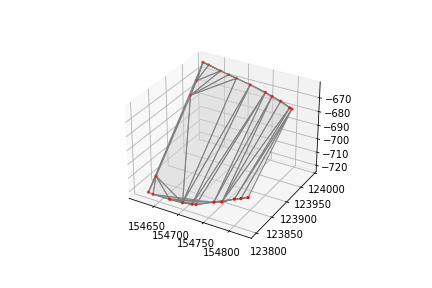

In [60]:
ftr = gpkg_dict['data'][1].geometry[0]
x, y, z = [], [], []
for p in ftr.exterior.coords:
    x.append(p[0])
    y.append(p[1])
    z.append(p[2])

# Plot X,Y,Z
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, color='white', edgecolors='grey', alpha=0.5)
ax.scatter(x,y,z, c='red', s=5)
plt.show()

In [30]:
pause

NameError: name 'pause' is not defined

### Testing zone =============================================================

Intersection with Point and Linestring cause issues because  

### =============================================================================

In [ ]:
cells_sel = [c for c in cells_coords if c[0] in isect_nodes] # select intersected cells from nodes number

In [ ]:
cells_sel[:2]

In [ ]:
annotations = dict(coords=cells_sel, marker=['x', 'r', 5])#, text_fmt=[10, 'b'], annot_type='node')#,  shift=(-100, 100), layer=1)

In [ ]:
layers = 0#list(np.arange(10,15))
model_map(gwf, annotations=annotations, layer_line=layers)#, figsize=(15,8), fig_col=1)

In [ ]:
pause

## Add stress packages to GWF (external flow into/out the system)

#### recharge (RCH) Package

In [ ]:
rch = fp.mf6.ModflowGwfrcha(gwf, recharge=3e-8) # recharge rate [ft/s]

In [ ]:
rch.recharge.array.shape

#### constant head (CHD) Package

In [ ]:
cells_sel = [i for i in cells_coords if i[1][0] in [0,1] and i[1][2] in [0]] # select all cells in column 0 for 2 first layers

In [ ]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations, layer_line=[0,1] + layers[:-3])#, figsize=(15,8), fig_col=1)

In [ ]:
# set head to null for selected cells
hd = 110
chd_rec = [(c[1], hd) for c in cells_sel] # ((l,r,c), head)

In [ ]:
chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_rec)  # set a constant head stress

#### drain (DRN) Package

In [ ]:
# select cells on row 7 for 1 < column < 8 in first layer
cells_sel = [i for i in cells_coords if i[1][0]==0 and i[1][1]==7 and (i[1][2]>0 and i[1][2]<30)] 

In [ ]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations, layer_line=layers)

In [ ]:
cond = 1.
elevation = np.random.randint(101,156,len(cells_sel))
drn_rec = [(c[1], elv, cond) for c, elv in zip(cells_sel, elevation)] # ((l,r,c), elev, cond)

In [ ]:
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_rec)

#### well (WEL) Package

In [ ]:
cells_sel1 = [i for i in cells_coords if i[1][0]==1 and i[1][1] in [9,11,13] and i[1][2] in [8,10,12,14]] # layer 1
cells_sel2 = [i for i in cells_coords if i[1][0]==2 and i[1][1] in [41,43,45] and i[1][2] in [8,10,12,14]] # layer 2
cells_sel = cells_sel1 + cells_sel2

In [ ]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations, layer_line=layers)

#### <font color=red>Get a simulation error when adding wells</font>

In [ ]:
wel_rec = []
q_pump, q_inj = -1000.0, 500 # well pumping and injection rate 
wel_rec = [(c[1], q_pump) for c in cells_sel1] # ((l,r,c), pump_rate)
wel_rec.extend([(c[1], q_inj) for c in cells_sel2])

#### output control (OC) Package

In [ ]:
# Save heads and budget output to binary files and print heads to the model listing file at the end of the stress period.
headfile = f"{model_name}.hds" # head information
head_filerecord = [headfile]
budgetfile = f"{model_name}.cbb" # flow terms are written here
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

oc = fp.mf6.ModflowGwfoc(gwf, saverecord=saverecord, head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord, printrecord=printrecord)

## Create the MODFLOW 6 Input Files and Run the Model

### Write the datasets

In [ ]:
sim.write_simulation()

### Run the simulation

In [ ]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

## Display results

#### Post-process head results

In [ ]:
head = gwf.output.head().get_data(kstpkper=(0, 0)) # kstpkper --> k time step, k stress period

#### Map of layers 

In [ ]:
kwargs = {'cnt_fmt':'%2.3f', 'cnt_label':10, 'figsize':(20, 5), 'cb_shrink':0.5, 'cmap':'RdBu'}# 'cmap':'gist_ncar'}

In [ ]:
model_map(model=gwf, plot_array=head, layer_line=layers, plot_type='map', fig_col=1, **kwargs)

#### Cross-section of heads along rows

In [ ]:
row_col = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=row_col, plot_type='row', annotations=annotations, fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'n_cnt':4, 'cnt_label':10, 'cnt_color':'k'})# 'cnt_intervals':np.arange(-1, 1, .1)})

#### Cross-section of heads along columns

In [ ]:
row_col = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=row_col, plot_type='column', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'cnt_label':15, 'cnt_intervals':np.arange(0, .5, .1)})

## Determine the Flow Residual

In [ ]:
flowja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[0]

In [ ]:
grb_file = f"{model_name}.dis.grb"
residual = fp.mf6.utils.get_residuals(flowja, grb_file=model_files +'/'+ grb_file)

#### Map of the flow error in Layer 10

In [ ]:
model_map(model=gwf, plot_array=residual, layer_line=layers, 
            **{'figsize':(20,10), 'cnt_fmt':"%.2f", 'cb_fmt':'%.1ef', 'cb_shrink':0.5})

# Test

In [ ]:
path='/home/rikl/Dokumente/Python/shapefile/customer_points.shp'
import osgeo.ogr, osgeo.osr #we will need some packages
from osgeo import ogr #and one more for the creation of a new field
spatialReference = osgeo.osr.SpatialReference() #will create a spatial reference locally to tell the system what the reference will be
spatialReference.ImportFromProj4('+proj=utm +zone=48N +ellps=WGS84 +datum=WGS84 +units=m') #here we define this reference to be utm Zone 48N with wgs84...
driver = osgeo.ogr.GetDriverByName('ESRI Shapefile') # will select the driver foir our shp-file creation.
shapeData = driver.CreateDataSource(path) #so there we will store our data
layer = shapeData.CreateLayer('customs', spatialReference, osgeo.ogr.wkbPoint) #this will create a corresponding layer for our data with given spatial information.
layer_defn = layer.GetLayerDefn() # gets parameters of the current shapefile
point = osgeo.ogr.Geometry(osgeo.ogr.wkbPoint) 
point.AddPoint(474595, 5429281) #create a new point at given ccordinates
featureIndex = 0 #this will be the first point in our dataset
##now lets write this into our layer/shape file:
feature = osgeo.ogr.Feature(layer_defn) 
feature.SetGeometry(point)
feature.SetFID(featureIndex)
layer.CreateFeature(feature)
## lets add now a second point with different coordinates:
point.AddPoint(474598, 5429281)
featureIndex = 1
feature = osgeo.ogr.Feature(layer_defn)
feature.SetGeometry(point)
feature.SetFID(featureIndex)
layer.CreateFeature(feature)
shapeData.Destroy() #lets close the shapefile
shapeData = ogr.Open(path, 1)
layer = shapeData.GetLayer() #get possible layers. was source.GetLayer
layer_defn = layer.GetLayerDefn() 
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())] #store the field names as a list of stringsprint len(field_names)# so there should be just one at the moment called "FID"
print len(field_names)# so there should be just one at the moment called "FID"
field_names #will show you the current field names
new_field = ogr.FieldDefn('HOMETOWN', ogr.OFTString) #we will create a new field called Hometown as String
layer.CreateField(new_field) #self explaining
new_field = ogr.FieldDefn('VISITS', ogr.OFTInteger) #and a second field 'VISITS' stored as integer
layer.CreateField(new_field) #self explaining
field_names = [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())]
field_names #WOOHAA!
feature = layer.GetFeature(0) #lets get the first feature (FID=='0')
i = feature.GetFieldIndex("HOMETOWN") #so iterate along the field-names and store it in iIndex
feature.SetField(i, 'Chicago') #exactly at this position I would like to write 'Chicago'
layer.SetFeature(feature) #now make the change permanent
feature = layer.GetFeature(1)
i = feature.GetFieldIndex("HOMETOWN")
feature.SetField(i, 'Berlin')
layer.SetFeature(feature)
shapeData = None #lets close the shape file again.
